In [1]:
## Most Important
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import cv2
## less Important
from functools import partial
import os
import joblib
from sklearn.model_selection import train_test_split

## tensorflow & Keras
import tensorflow as tf    
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
train_images = Path(r'../input/arabic-hwr-ai-pro-intake1/train')

## read these all training images paths as Series
train_images_paths = pd.Series(sorted(list(train_images.glob(r'*.png'))), name='Filepath').astype(str)

## Images Exploration

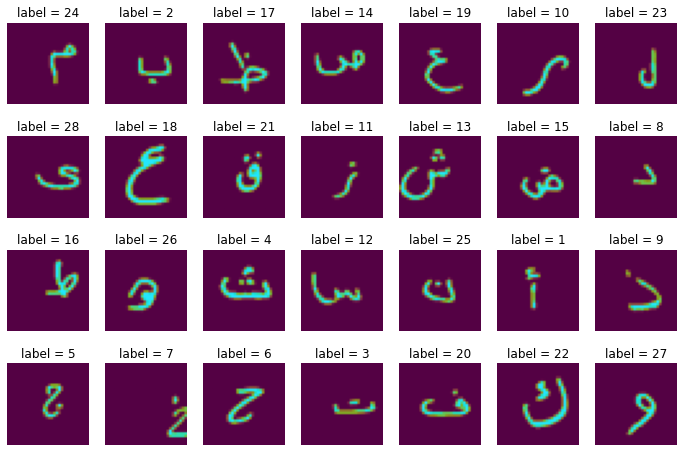

In [3]:
img_key_value = {}
for value in train_labels['label'].unique():
    img_key_value[value] = train_labels[train_labels['label']==value].index[0]
    
img_index = list(img_key_value.values())
img_label = list(img_key_value.keys())

fig, ax = plt.subplots(4, 7, figsize=(12, 8))

i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        plt.title(f'label = {img_label[i]}')
        img = plt.imread(train_images_paths.iloc[img_index[i]])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        i+=1

In [4]:
print('Number of Instances in train_set =>', len(train_images_paths))
print('Number of Instances in train_labels =>', len(train_labels))

img = plt.imread(train_images_paths.iloc[img_index[0]])
print('shape of each Image is =>', img.shape)

Number of Instances in train_set => 13440
Number of Instances in train_labels => 13440
shape of each Image is => (32, 32, 4)


## Data Preprocessing

In [5]:
train_full_labels = tf.keras.utils.to_categorical(train_labels['label'].values -1 ,num_classes=train_labels['label'].nunique())

train_full_set = np.empty((13440, 32, 32, 1), dtype=np.float32)  

for idx, path in enumerate(train_images_paths):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(img,axis=2)
    train_full_set[idx] = img
    
print('train_full_set.shape =>', train_full_set.shape)
print('train_full_labels.shape =>', train_full_labels.shape)

train_full_set.shape => (13440, 32, 32, 1)
train_full_labels.shape => (13440, 28)


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_full_set, train_full_labels, 
                                                      test_size=0.2,stratify=train_full_labels, random_state=42)

print('X_train.shape =>', X_train.shape)
print('X_valid.shape =>', X_valid.shape)
print('y_train.shape =>', y_train.shape)
print('y_valid.shape =>', y_valid.shape)

X_train.shape => (10752, 32, 32, 1)
X_valid.shape => (2688, 32, 32, 1)
y_train.shape => (10752, 28)
y_valid.shape => (2688, 28)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return 

def rescale(img):
    return img/255.0

train_datagen = ImageDataGenerator(
        rotation_range=30
        ,shear_range=0.1
        ,zoom_range=0.15
        ,width_shift_range=0.2
        ,height_shift_range=0.2
        ,preprocessing_function=rescale
)

train_gen = train_datagen.flow(x=X_train, y=y_train, batch_size=32,shuffle=True)

test_datagen = ImageDataGenerator(preprocessing_function=rescale)
test_gen = test_datagen.flow(x=X_valid, y=y_valid, batch_size=32)


## Generator Output debuging

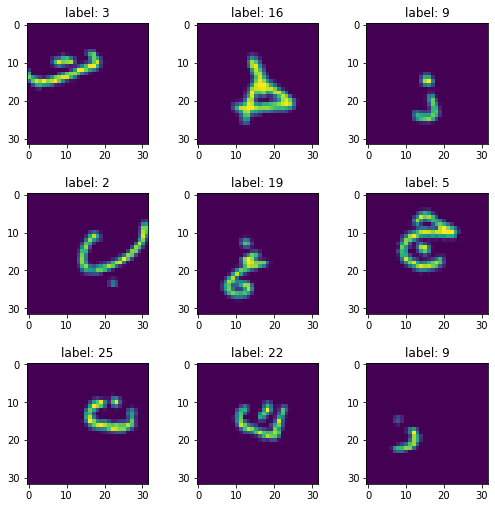

In [8]:
fig, axes = plt.subplots(3,3,figsize=(8,8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
axes = axes.flatten()
for batch in train_gen:
    imgs,labels = batch
    for i in range(9):
        plt.sca(axes[i])
        plt.title(f"label: {np.argmax(labels[i])+1}")
        plt.imshow(imgs[i])
    break

## Model Training

## skip connection meta arch model

In [9]:
def skip_model():
    inputs = tf.keras.layers.Input(shape=(32,32,1))
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3,padding='same',activation='elu')(inputs)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=5,padding='same',activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    skip_conn_1 = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3,padding='same',activation='elu')(skip_conn_1)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5,padding='same',activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([skip_conn_1,x])
    skip_conn_2 = tf.keras.layers.MaxPooling2D(pool_size=2)(x)


    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3,padding='same',activation='elu')(skip_conn_2)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=5,padding='same',activation='elu',name="feature_map")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([skip_conn_2,x])
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)


    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(64,activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(28,activation='softmax')(x)

    return tf.keras.Model(inputs=inputs,outputs=outputs)

## inception model meta arch

In [10]:
def inception_model():
    inputs = tf.keras.layers.Input(shape=(32,32,1))

    ######################################################################################
    conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv_block_1 = tf.keras.layers.ELU()(conv1)

    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5,padding='same')(inputs)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv_block_2 = tf.keras.layers.ELU()(conv2)

    feature_map_1 = tf.keras.layers.Concatenate()([conv_block_1,conv_block_2])
    feature_map_1 = tf.keras.layers.MaxPooling2D(pool_size=2)(feature_map_1)

    #######################################################################################
    conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,padding='same')(feature_map_1)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv_block_3 = tf.keras.layers.ELU()(conv3)

    conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=5,padding='same')(feature_map_1)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv_block_4 = tf.keras.layers.ELU()(conv4)

    feature_map_2 = tf.keras.layers.Concatenate()([conv_block_3,conv_block_4])
    feature_map_2 = tf.keras.layers.MaxPooling2D(pool_size=2)(feature_map_2)
    ########################################################################################

    conv5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,padding='same')(feature_map_2)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv_block_5 = tf.keras.layers.ELU()(conv5)

    conv6 = tf.keras.layers.Conv2D(filters=128, kernel_size=5,padding='same')(feature_map_2)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv_block_6 = tf.keras.layers.ELU()(conv6)

    feature_map_3 = tf.keras.layers.Concatenate()([conv_block_5,conv_block_6])
    feature_map_3 = tf.keras.layers.MaxPooling2D(pool_size=2,name='feature_map')(feature_map_3)

    x = tf.keras.layers.Flatten()(feature_map_3)

    x = tf.keras.layers.Dense(256,activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(28,activation='softmax')(x)

    return tf.keras.Model(inputs=inputs,outputs=outputs)

In [11]:
model = inception_model()
model.summary()

2021-11-07 18:57:23.484690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 18:57:23.584441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 18:57:23.585215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 18:57:23.586331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
lr = 1e-2
def exponential_decay_fn(epoch):
    return lr * 0.1**(epoch / 5)
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
early_stopp = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [13]:
history = model.fit(train_gen, validation_data=test_gen, 
                              epochs=60,
                              steps_per_epoch=336,
                              validation_steps=84,
                              callbacks=[early_stopp,lr_scheduler])

2021-11-07 18:57:26.282967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2021-11-07 18:57:28.199317: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


336/336 [==============================] - 13s 17ms/step - loss: 2.5299 - accuracy: 0.2714 - val_loss: 4.0710 - val_accuracy: 0.1443
Epoch 2/60
336/336 [==============================] - 5s 15ms/step - loss: 1.2752 - accuracy: 0.5823 - val_loss: 14.1272 - val_accuracy: 0.0376
Epoch 3/60
336/336 [==============================] - 5s 15ms/step - loss: 0.8453 - accuracy: 0.7203 - val_loss: 16.8397 - val_accuracy: 0.0766
Epoch 4/60
336/336 [==============================] - 5s 14ms/step - loss: 0.6556 - accuracy: 0.7932 - val_loss: 0.6435 - val_accuracy: 0.7872
Epoch 5/60
336/336 [==============================] - 5s 16ms/step - loss: 0.5169 - accuracy: 0.8322 - val_loss: 0.3287 - val_accuracy: 0.8955
Epoch 6/60
336/336 [==============================] - 5s 15ms/step - loss: 0.4528 - accuracy: 0.8558 - val_loss: 0.4665 - val_accuracy: 0.8590
Epoch 7/60
336/336 [==============================] - 6s 17ms/step - loss: 0.4160 - accuracy: 0.8653 - val_loss: 0.3718 - val_accuracy: 0.8646
Epoch 8

## GradCamp HeatMap

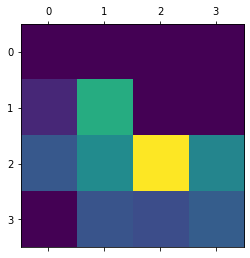

In [14]:
import numpy as np
from tensorflow.keras import backend as K

# The local path to our target image
img_path = '../input/arabic-hwr-ai-pro-intake1/train/00101.png'

img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)

img = np.expand_dims(img, axis=2)
img = np.expand_dims(img, axis=0)
img = img/255.0

conv_layer = model.get_layer("feature_map")
heatmap_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
#print(heatmap.shape)
heatmap = np.reshape(heatmap,(4,4))
plt.matshow(heatmap)
plt.show()

(32, 32, 3)


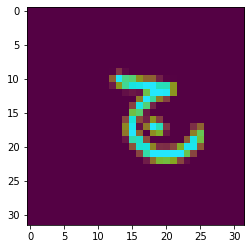

In [15]:
image = cv2.imread(img_path)
plt.imshow(image)
print(image.shape)

(32, 32, 3)


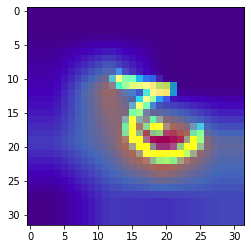

In [16]:
heatmap = cv2.resize(heatmap, (image.shape[0], image.shape[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print(heatmap.shape)
superimposed_img = heatmap * 0.4 + image
cv2.imwrite('inspection.png', superimposed_img)

inspect= cv2.imread("./inspection.png")
inspect = cv2.cvtColor(inspect,cv2.COLOR_BGR2RGB)
plt.imshow(inspect)
plt.show()

## Model Accuracies and Losses

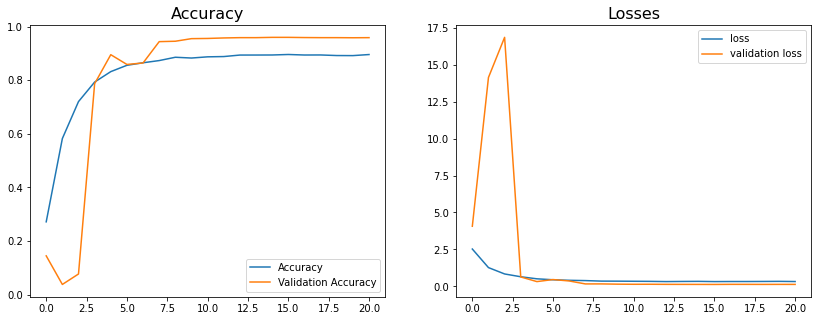

In [17]:
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
ax_1.plot(history.history['accuracy'],label='Accuracy')
ax_1.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy',fontsize=16)
plt.legend()

ax_2 = fig.add_subplot(122)
ax_2.plot(history.history['loss'],label='loss')
ax_2.plot(history.history['val_loss'],label='validation loss')
plt.title('Losses',fontsize=16)
plt.legend()

plt.show()

### Model Evaluation over all dataset

In [18]:
loss_all_data, acc_all_data = model.evaluate(train_full_set/255.0, train_full_labels, verbose=0)
print('loss_all_data =>', loss_all_data)
print('acc_all_data =>', acc_all_data)

loss_all_data => 0.12915968894958496
acc_all_data => 0.9612351059913635


## Evaluation on Testing DataSet

In [19]:
test_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')
test_images = Path(r'../input/arabic-hwr-ai-pro-intake1/test')

## read these all training images paths as Series
test_images_paths = pd.Series(sorted(list(test_images.glob(r'*.png'))), name='Filepath').astype(str)

test_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/test/00000.png
1    ../input/arabic-hwr-ai-pro-intake1/test/00001.png
2    ../input/arabic-hwr-ai-pro-intake1/test/00002.png
3    ../input/arabic-hwr-ai-pro-intake1/test/00003.png
4    ../input/arabic-hwr-ai-pro-intake1/test/00004.png
Name: Filepath, dtype: object

In [20]:
print('Number of Instances in test_set is', len(test_images_paths))

Number of Instances in test_set is 3360


In [21]:
test_full_set = np.empty((3360, 32, 32, 1), dtype=np.float32) 
test_full_set = test_full_set
for idx, path in enumerate(test_images_paths):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(img,axis=2)
    test_full_set[idx] = img
    
print('test_full_set.shape =>', test_full_set.shape)

test_full_set.shape => (3360, 32, 32, 1)


In [22]:
y_preds_classes = np.argmax(model.predict(test_full_set/255.0), axis=-1) + 1
test_labels['label'] = y_preds_classes


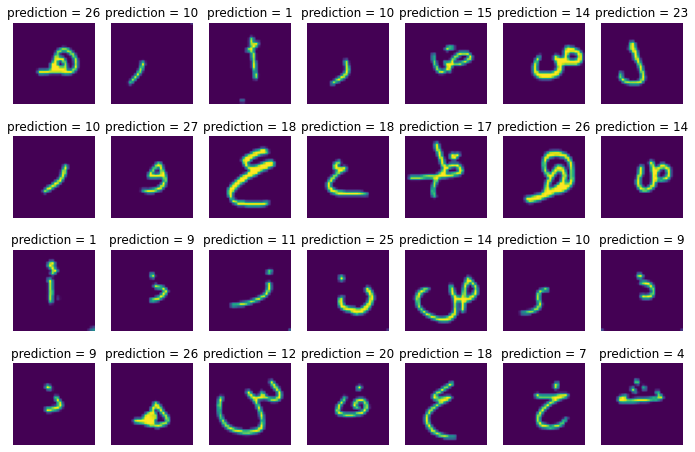

In [23]:
fig, ax = plt.subplots(4, 7, figsize=(12, 8))

i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        plt.title(f'prediction = {y_preds_classes[i]}')
        img = test_full_set[i]
        plt.imshow(img)
        plt.axis('off')
        i+=1

In [24]:
test_labels[['id', 'label']].to_csv('/kaggle/working/submission.csv', index=False)